In [128]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
import random
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')
mpl.rcParams['pdf.fonttype'] = 42

# import

In [2]:
dataVis108_AL35 = wfOpto(Path(r'Y:\Subjects\AL_0035\2025-01-08\1'))

In [93]:
dataVis1209_AL35 = wfOpto(Path(r'Y:\Subjects\AL_0035\2024-12-09\1'))

In [94]:
dataVis823_ZYE88 = wfOpto(Path(r'Y:\Subjects\ZYE_0088\2024-08-23\1'))

In [90]:
# linearity test
path = Path(r'Y:/Subjects/AL_0035/2025-01-08/2')
exp2Contrasts = np.load(path / 'linTestContrasts.npy')
exp2Dur = np.load(path / 'linTestDurations.npy')
exp2On = np.load(path / 'linTestOnTimes.npy')
exp2Off = np.load(path/ 'linTestOffTimes.npy')

# analysis functions

## extracting parameters

In [97]:
NF_AL35108 = dataVis108_AL35.getExp(1,2)
NF_AL351209 = dataVis1209_AL35.getExp(1,3)
NF_ZYE8823 = dataVis823_ZYE88.getExp(1,3)

## baseline and trial t-test

In [ ]:
def returnbaselines(data,exp,galvoX,galvoY,baseline_ind,test_ind,start=-.3,end=0.1,width=30,x=120,y=380):
    #my indices 
    n_samples = round((end-start) * 35)
    basesamps = round(start*35*-1)

    galvoX=np.argwhere(exp.galvoX==galvoX).ravel()
    galvoY=np.argwhere(exp.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoX,galvoY)

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    meanim = data.meanImage.reshape(560*560,-1)
    meanroi = meanim[flat_indices]

    #checkers
    baselines=[]
    activities=[]

    powers=np.unique(exp.laserPowers)
    for i,pow in enumerate(powers):
        #get our trial activity for both baseline period and stim period 
        pwTrs = np.argwhere(exp.laserPowers == pow).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = exp.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            mov = mov + meanroi
            mov_area_avg = np.mean(mov,axis=0)
            mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
            baseline_mean = np.mean(mov_abs[:int(basesamps)]) #mean of the baseline period from that absolute value-d trial values
            dff = (mov_abs - baseline_mean) / baseline_mean #dff calculation where absolute valued vals - baseline / baseline 
            trial_activity.append(dff)
        trial_activity=np.array(trial_activity)

        #get my threshold
        baselines.append(trial_activity[:,:baseline_ind])
        activities.append(trial_activity[:,test_ind:])
    baselines = np.mean(baselines,axis=2)
    activities=np.mean(activities,axis=2)
    return baselines, activities

# a

image of the brain after a laser is shone on the front of the brain

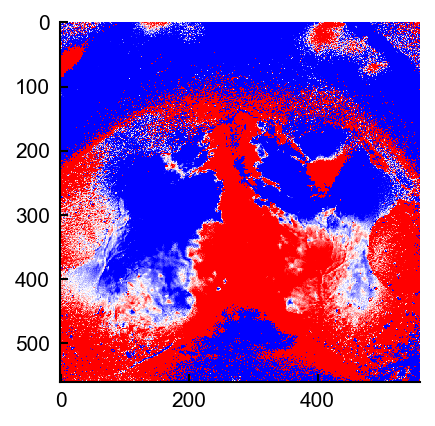

In [88]:
fig,ax=plt.subplots(1,1,figsize=(3,3))
data=dataVis108_AL35
exp=NF_AL35108
power=2
galvoX=0;galvoY=0;start=-.3;end=1
basesamps=round(35*start*-1)
frame=5
n_samples=round(35*(end-start))

pows = np.argwhere(exp.laserPowers==power).ravel()
galvoYTrs=np.argwhere(exp.galvoY==galvoY)
galvoXTrs=np.argwhere(exp.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = exp.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0) #46 times x 50 components
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t), 313600 pixels x 46 times 
mov_abs = mov + np.abs(np.min(mov))
mov_re = mov.reshape(560,560,-1)

baseline = mov[:,:basesamps]
baseline_re = baseline.reshape(560,560,-1)
meanim = np.mean(baseline_re,axis=2)
meanim = meanim.reshape(560,560,-1)

dff = (mov_re - meanim) / meanim

plt.imshow(dff[:,:,frame],cmap='bwr',vmin=-0.1,vmax=0.1)

# pct99 = np.percentile(np.abs(dff), 99)
# clim = np.r_[-1, 1]*pct99
# im = ax.imshow(dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
# plt.axis('off')
# cbar=plt.colorbar(im,ax=ax,location='right')
# cbar.set_ticks([-0.003,0.003])
# cbar.set_ticklabels(['-3','3'])
# cbar.ax.tick_params(size=0)
# cbar.outline.set_visible(False)
# cbar.set_label('% dF/F')

# b

trace of visresp to laser

([], [])

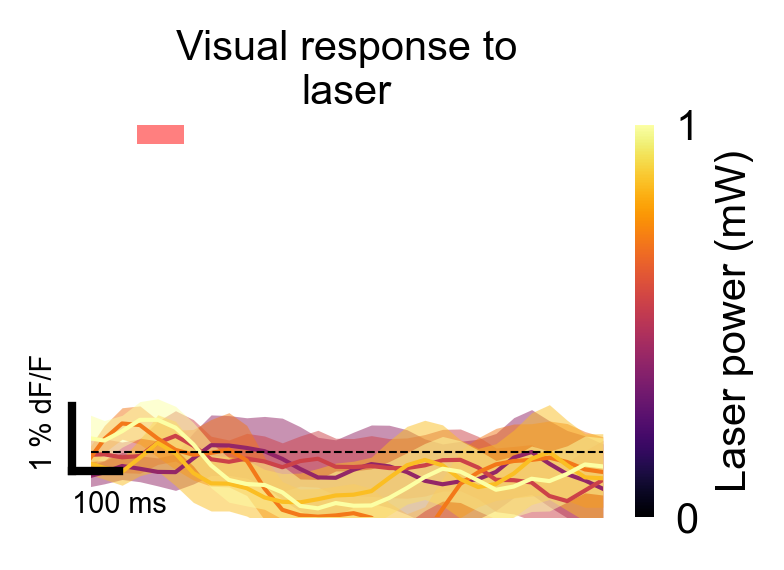

In [210]:
data=dataVis823_ZYE88
exp=NF_ZYE8823

powers=np.unique(exp.laserPowers)
galvoX=0;galvoY=0;x=120;y=380;width=15;anchor=(1,1)
start=-0.3;end=1
basesamps = start*-1*35
n_samples = round(start*-1+end)*35
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(exp.galvoX==galvoX).ravel()
galvoYTr=np.argwhere(exp.galvoY==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

meanim = data.meanImage.reshape(560*560,-1)
meanroi = meanim[flat_indices]

pxPowers = []
sems=[]

for power in powers:
    pwTrs = np.argwhere(exp.laserPowers == power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = exp.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial) #temporal components for trial
        mov = data.svdSpat[flat_indices] @ wf.T #add in spatial 
        mov = mov + meanroi # adding back the mean from the session to the trial spat/temp components to get 'original' data
        mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
        mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg)) #add back in the min value to make all positive
        baseline_mean = np.mean(mov_abs[:int(basesamps)]) #mean of the baseline period from that absolute value-d trial values
        dff = (mov_abs - baseline_mean) / baseline_mean #dff calculation where absolute valued vals - baseline / baseline 
        trial_activity.append(dff)
    pxPowers.append(np.mean(trial_activity,axis=0))
    sems.append(scipy.stats.sem(trial_activity,axis=0))

fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]
ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.100,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.01 # length of dff bar
x_start = 0 - 0.14 # where the bar should start
y_start = -0.003 # where the bar should start

plt.ylim([-.01,.05])
plt.xlim([-.1,1])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.003, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.03, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# c

linearity test

([], [])

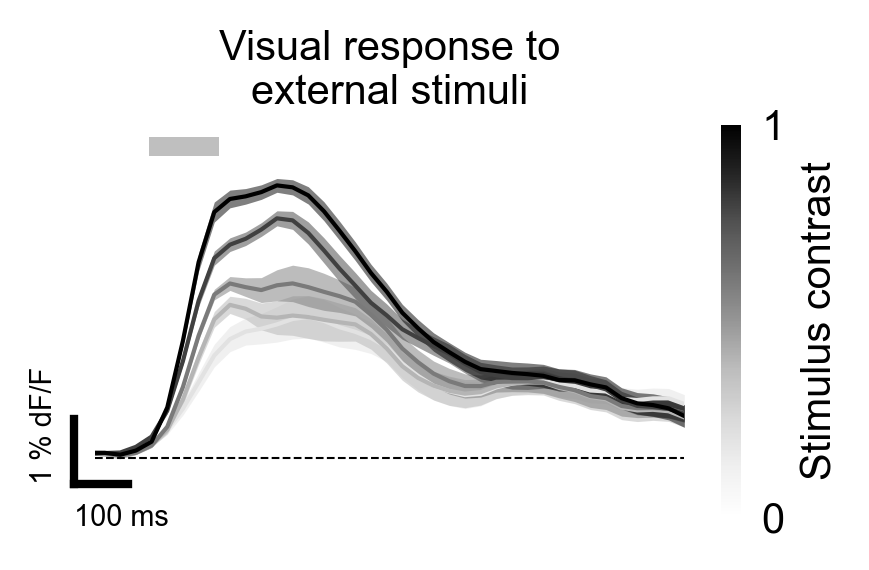

In [91]:
data=dataVis108_AL35
x=120
y=415
width=15
start=-0.2
end=1
colors_grey = plt.cm.Greys(np.linspace(0.2,1,5))

meanimg = data.meanImage.reshape(560,560,-1)
avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
pxCon=[]
sems=[]

n_samples=round((start*-1+end)*35)
for contrast in np.unique(exp2Contrasts):
    contrs = np.argwhere(exp2Contrasts==contrast).ravel()
    onTimes = exp2On[contrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        mov = mov + meanroi # adding back the mean from the session to get to true 'raw'
        mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
        mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
        baseline_mean = np.mean(mov_abs[0:7])
        dff = (mov_abs - baseline_mean) / baseline_mean
        trial_activity.append(dff)
    sems.append(scipy.stats.sem(trial_activity,axis=0))
    pxCon.append(np.mean(trial_activity,axis=0))
    
fig,ax=plt.subplots(figsize=(3,2),dpi=300)

times=np.linspace(start,end,n_samples)
for iC,contrast in enumerate(pxCon):
    plt.plot(times,contrast,color=colors_grey[iC])
    plt.fill_between(times, \
            contrast-sems[iC],\
            contrast+sems[iC], color=colors_grey[iC],label='_nolegend_',alpha=.5,linewidth=0)
plt.axvspan(0,.130,ymin=0.92,ymax=0.97,color='grey',alpha=0.5,lw=0)

cm = mpl.cm.ScalarMappable(cmap='Greys') # creates a color mapping objec
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7:.1f} mW') # the power variable is in V (taken from data npys)
cbar=plt.colorbar(ax=ax,mappable=cm,label='Stimulus contrast') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
plt.title('Visual response to\nexternal stimuli')

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.01 # length of dff bar
x_start = 0 - 0.14 # where the bar should start
y_start = -0.005 # where the bar should start
plt.ylim([-.01,.05])
plt.xlim(-0.1,1)
plt.axhline(-0.001, xmin=0,xmax=4,color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.003, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.03, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# d

location vs visresp

In [211]:
def respQuantLocReturnDict(data,exp,galvoYList,powers,x=100,y=390,\
                 time=0.18,width=50):
    '''
    plots 3 traces for 3 different locations to compare the activation of the visual cortex per location
    '''
    pxData=[]
    sems_final=[]
    trial_peaks_saved=[]
    start=-.3
    end=.5
    baselinesamps=round(35*start*-1)
    n_samples = round((start+end)*35)
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    meanim = data.meanImage.reshape(560*560,-1)
    meanroi = meanim[flat_indices]

    for iD,yLoc in enumerate(galvoYList):
        pxPowers={}
        sems={}
        locPeaks={}
        galvoYTrs=np.argwhere(exp.galvoY==yLoc).ravel()

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(exp.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,galvoYTrs)
            onTimes = exp.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                mov = mov + meanroi # adding back the mean from the session to the trial spat/temp components to get 'original' data
                mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
                mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
                baseline_mean = np.mean(mov_abs[:baselinesamps])
                dff = (mov_abs - baseline_mean) / baseline_mean
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems[power]=[scipy.stats.sem(trial_peaks,axis=0)]
            pxPowers[power]=[(np.mean(trial_peaks,axis=0))]
            locPeaks[power]=(trial_peaks)
        trial_peaks_saved.append(locPeaks)
        pxData.append(pxPowers)
        sems_final.append(sems)

    return pxData,sems_final,trial_peaks_saved

In [212]:
# loc8,semsLoc8,trial_peaks8 = respQuantLocReturnDict(data=dataVis823_ZYE88,exp=NF_ZYE8823,galvoYList=[0,2.5,4.5],powers=np.unique(dataVis823_ZYE88.laserPowers),\
#              x=120,y=415,time=0.18,width=15)
loc10,semsLoc10,trial_peaks10 = respQuantLocReturnDict(data=dataVis1209_AL35,exp=NF_AL351209,galvoYList=[0,1.5,3],powers=np.unique(dataVis1209_AL35.laserPowers),\
             x=120,y=415,time=0.18,width=15)
loc19,semsLoc19,trial_peaks19 = respQuantLocReturnDict(data=dataVis108_AL35,exp=NF_AL35108,galvoYList=[0,2,3.5],powers=np.unique(dataVis108_AL35.laserPowers),\
             x=120,y=415,time=0.18,width=15)

In [213]:
locPowerDicts = [trial_peaks10,trial_peaks19]
for i in range(3): # loop through the three locations
    refPws = locPowerDicts[0][i] # chose the first dataset as reference
    for j in range(1,len(locPowerDicts)): # loop through the other datasets, excluding the first because that is our reference
        testPw = locPowerDicts[j][i] # get the right dataset (j) for the right location (i)
        for key in testPw.keys(): # for power in the test dictionary
            if key in refPws.keys(): # if the power is already in the reference dictionary
                random_trs = random.sample(testPw[key],35)
                refPws[key].extend(random_trs) # extend the list with the values of that key in the other list
            else: # if the power is not in the reference dictionary
                random_trs = random.sample(testPw[key],35)
                refPws[key] = testPw[key] # add the key and value to the first list 
        locPowerDicts[0][i] = refPws
trialPeaks = locPowerDicts[0] #we used the first entry as reference, so that is our final list of all pws etc. 
                                # the shape is 3 locations x dict with powers: trial peaks across mice

# now find the standard error of the mean for each power at each location
sems = [] # instantiate list that will hold dict for each power
for loc in range(3): #loop through the three locations
    sems_loc = {} # instantiate dict for each location
    for power in trialPeaks[loc].keys(): # loop through the powers (keys of trial_peaks)
        sems_loc[power] = scipy.stats.sem(trialPeaks[loc][power],axis=0) # calculate the sem for each power
    sems.append(sems_loc)

# find mean values for each power across trs
meanPeaks = [] # instantiate list that will hold dict for each power
for loc in range(3): # loop through the three locations
    meanPeaks_loc = {} # instantiate dict for each location
    for power in trialPeaks[loc].keys(): # loop through the powers (keys of trial_peaks)
        meanPeaks_loc[power] = np.mean(trialPeaks[loc][power],axis=0) # calculate the mean for each power
    meanPeaks.append(meanPeaks_loc)

In [224]:
# find significance

baselinesAL,activitiesAL=returnbaselines(data=dataVis108_AL35,exp=NF_AL35108,galvoX=0,galvoY=0,baseline_ind=7,test_ind=7,start=-.2,end=0.2,width=15)
baselinesZYE1,activitiesZYE1=returnbaselines(dataVis1209_AL35,NF_AL351209,galvoX=0,galvoY=0,x=415,y=415,baseline_ind=7,test_ind=7,start=-.2,end=0.2,width=15)

for i in range(11):
    concat_baselines = np.concatenate((baselinesAL[i],baselinesZYE1[i]))
    concat_activities = np.concatenate((activitiesAL[i],activitiesZYE1[i]))
    print(scipy.stats.ttest_rel(concat_baselines,concat_activities,axis=0))

TtestResult(statistic=-1.73991923227204, pvalue=0.08603064782851808, df=74)
TtestResult(statistic=-0.9810838206070118, pvalue=0.3297481374498026, df=74)
TtestResult(statistic=-2.570798422528291, pvalue=0.012155625138966024, df=74)
TtestResult(statistic=-2.8888391906091626, pvalue=0.005068941994040058, df=74)
TtestResult(statistic=-2.2076773081096794, pvalue=0.030366215266552345, df=74)
TtestResult(statistic=-4.875696359590413, pvalue=6.028462051723704e-06, df=74)


IndexError: index 6 is out of bounds for axis 0 with size 6

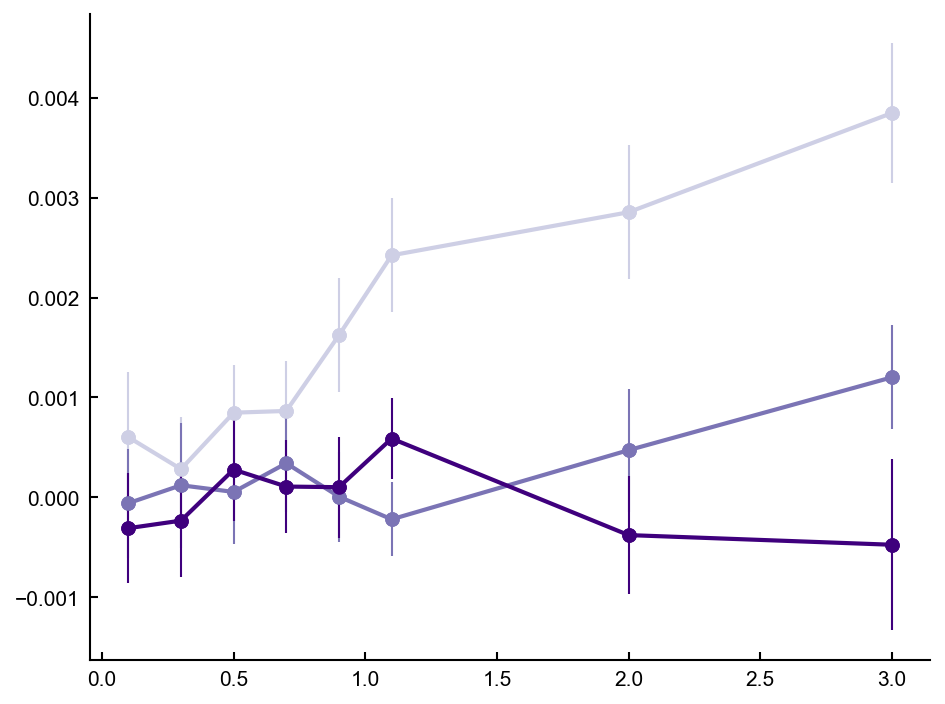

In [215]:
labels=['Ant','Mid','Post']
colors = plt.cm.Purples(np.linspace(.3,1,3))
powers = list(trialPeaks[0].keys())
sorted_powers = sorted(powers)
for loc in range(3):
    mean_values = [meanPeaks[loc][power] for power in sorted_powers]
    sem_values = [sems[loc][power] for power in sorted_powers]
    
    plt.plot(sorted_powers, mean_values, color=colors[loc], lw=2)
    plt.scatter(sorted_powers, mean_values, color=colors[loc])
    plt.errorbar(sorted_powers, mean_values, yerr=sem_values, color=colors[loc], fmt='o')